In [85]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# 保证可以从项目根目录导入 amr_optimizer
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'src').is_dir():
    PROJECT_ROOT = PROJECT_ROOT.parent
import sys
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.Bayesian_state.utils.amr_optimizer import AMRGridSearch
print(f'Using project root: {PROJECT_ROOT}')

Using project root: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning


In [86]:
# 测试一个平滑但多峰的非凸目标：Rastrigin-like 变体（平移并缩放）
# 最优点在 (0.3, 0.7)，理论最优值接近 0

import math

def func(*, a, freq, term_x, term_y):
    return a * 2 + (term_x ** 1 - a * math.cos(4 * math.pi * freq * term_x)) \
                      + (term_y ** 2 - a * math.cos(2 * math.pi * freq * term_y))


a = 5.0  # 振幅系数，越小越平滑
freq = 2.0  # 频率因子，控制多峰程度


def objective(params: dict[str, float]) -> float:
    x = params['gamma']
    y = params['w0']
    # 平移中心到 (0.3, 0.7)，缩放频率，降低振幅以保持平滑
    term_x = (x - 0.32)
    term_y = (y - 0.7)
    rastrigin = func(a=a, freq=freq, term_x=term_x, term_y=term_y)
    return rastrigin

bounds = {
    'gamma': (0.0, 1.0),
    'w0': (0.0, 1.0),
}

opt = AMRGridSearch(
    bounds=bounds,
    objective=objective,
    max_evals=1000,
    max_depth=8,
    split_factor=2,          # 分裂
    coarse_grid_per_dim=4,   # 初始每维4点粗网格
    coarse_keep_top_k=6,    # 初始保留6个最优单元格

)
result = opt.run()
print('Best params:', result.best_params)
print('Best score:', result.best_score)


Best params: {'gamma': 0.0703125, 'w0': 0.6953125}
Best score: -0.24083936649127757


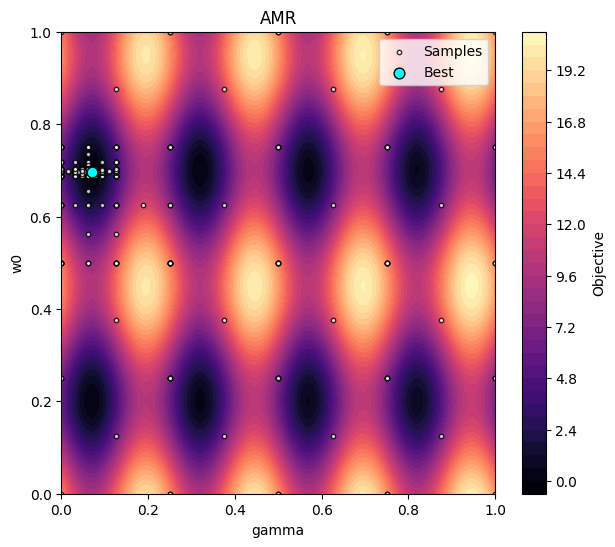

In [87]:
# 可视化搜索历史：等高线 + 采样点
history = result.history
xs = np.array([p['gamma'] for p, _ in history])
ys = np.array([p['w0'] for p, _ in history])
zs = np.array([s for _, s in history])

# 绘制目标函数等高线（非凸）
grid_x = np.linspace(bounds['gamma'][0], bounds['gamma'][1], 120)
grid_y = np.linspace(bounds['w0'][0], bounds['w0'][1], 120)
gx, gy = np.meshgrid(grid_x, grid_y)

# 与 objective 同步的栅格计算
A = a
rastrigin_grid = A * 2 + ((gx - 0.3) ** 1 - A * np.cos(4 * np.pi * freq * (gx - 0.32))) \
                    + ((gy - 0.7) ** 2 - A * np.cos(2 * np.pi * freq * (gy - 0.7)))

plt.figure(figsize=(7, 6))
cs = plt.contourf(gx, gy, rastrigin_grid, levels=40, cmap='magma')
plt.colorbar(cs, label='Objective')
plt.scatter(xs, ys, c='white', s=10, edgecolors='k', alpha=0.8, label='Samples')
plt.scatter([result.best_params.get('gamma', np.nan)], [result.best_params.get('w0', np.nan)],
            c='cyan', s=60, edgecolors='k', label='Best')
plt.xlabel('gamma')
plt.ylabel('w0')
plt.title('AMR')
plt.legend()
plt.show()
